In [1]:
import jax
import jax.numpy as jnp
from flax.core.frozen_dict import FrozenDict

from optimizers import PAGE, SGD
from test_opts import MLP

import matplotlib.pyplot as plt


In [2]:
KEY = jax.random.PRNGKey(42)

In [3]:
XDIM = 128
BS = 256
BS_HAT = 16

true_A = jax.random.uniform(KEY, (XDIM, 1))

def generate_batch(batch_size=BS, key: jax.random.PRNGKey=KEY) -> tuple[jnp.ndarray, jnp.ndarray]:
    x = jax.random.uniform(key, (batch_size, XDIM), minval=0, maxval=3)
    y = jnp.dot(x, true_A) + jax.random.normal(key, (batch_size, 1))*0.01
    return x, y

In [4]:
model = MLP()
init_batch = generate_batch(BS)
variables = model.init(KEY, init_batch[0])

def loss_fn(variables: FrozenDict, batch: tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:
    x, y = batch
    pred = model.apply(variables, x)
    return jnp.mean((pred - y) ** 2), {}

opt = PAGE(loss_fn=loss_fn,
           eval_loss_fn=loss_fn,
           p=BS_HAT/(BS+BS_HAT),
           lr=1e-5,
           bs=BS,
           bs_hat=BS_HAT,
           need_jit=True)
state = opt.init(variables, init_batch)

In [5]:
# %%time
x_page = []
losses_tmp = []
losses_page = []

for step in range(20_000):
	KEY, train_key = jax.random.split(KEY)
	batch = generate_batch(BS, train_key)
	loss, state = opt.update(state, batch)
	losses_tmp.append(loss)
	if (step + 1) % 100 == 0 or step == 499:
		x_page.append(opt.computed_grad_count / (step+1))
		losses_page.append(jnp.mean(jnp.array(losses_tmp)))
		losses_tmp = []
		print(f"Step {step} | Loss: {loss:.4f}")

Step 99 | Loss: 11.3335
Step 199 | Loss: 15.0533
Step 299 | Loss: 16.3399
Step 399 | Loss: 5.6938
Step 499 | Loss: 9.5798
Step 599 | Loss: 11.6737
Step 699 | Loss: 7.3257
Step 799 | Loss: 9.6339
Step 899 | Loss: 15.5503
Step 999 | Loss: 7.2642
Step 1099 | Loss: 8.0047
Step 1199 | Loss: 4.9808
Step 1299 | Loss: 5.0002
Step 1399 | Loss: 5.3481
Step 1499 | Loss: 6.3596
Step 1599 | Loss: 6.4413
Step 1699 | Loss: 7.5547
Step 1799 | Loss: 7.4169
Step 1899 | Loss: 2.5605
Step 1999 | Loss: 6.8964
Step 2099 | Loss: 3.3824
Step 2199 | Loss: 2.3241
Step 2299 | Loss: 2.8481
Step 2399 | Loss: 3.1209
Step 2499 | Loss: 3.3250
Step 2599 | Loss: 2.4132
Step 2699 | Loss: 4.1109
Step 2799 | Loss: 2.4452
Step 2899 | Loss: 3.5491
Step 2999 | Loss: 3.5074
Step 3099 | Loss: 2.2270
Step 3199 | Loss: 1.4301
Step 3299 | Loss: 2.0768
Step 3399 | Loss: 2.1805
Step 3499 | Loss: 2.0192
Step 3599 | Loss: 1.9241
Step 3699 | Loss: 0.4843
Step 3799 | Loss: 1.6845
Step 3899 | Loss: 1.3969
Step 3999 | Loss: 2.8118
Step 4

In [6]:
model = MLP()
x0, _ = generate_batch(BS)
variables = model.init(KEY, x0)

def loss_fn(variables, batch: tuple[jnp.ndarray, jnp.ndarray], train: bool = True) -> jnp.ndarray:
    x, y = batch
    logits = model.apply(variables, x)
    return jnp.mean((logits - y) ** 2), {}

opt = SGD(lr=1e-5, loss_fn=loss_fn)
state =opt.init(variables)

x_sgd = []
losses_tmp = []
losses_sgd = []

for step in range(20_000):
	train_key, KEY = jax.random.split(KEY)
	batch = generate_batch(BS, train_key)
	loss, state = opt.update(state, batch)
	losses_tmp.append(loss)
	if (step + 1) % 100 == 0 or step == 499:
		x_sgd.append(opt.computed_grad_count / (step+1))
		losses_sgd.append(jnp.mean(jnp.array(losses_tmp)))
		losses_tmp = []
		print(f"Step {step} | Loss: {loss:.4f}")

Step 99 | Loss: 12.6216
Step 199 | Loss: 13.8319
Step 299 | Loss: 11.9383
Step 399 | Loss: 10.6052
Step 499 | Loss: 10.9285
Step 599 | Loss: 11.9748
Step 699 | Loss: 9.5831
Step 799 | Loss: 9.6274
Step 899 | Loss: 8.2261
Step 999 | Loss: 6.8046
Step 1099 | Loss: 6.9235
Step 1199 | Loss: 7.2645
Step 1299 | Loss: 7.1414
Step 1399 | Loss: 6.3666
Step 1499 | Loss: 5.9824
Step 1599 | Loss: 5.5014
Step 1699 | Loss: 5.9152
Step 1799 | Loss: 4.8386
Step 1899 | Loss: 3.8848
Step 1999 | Loss: 4.8746
Step 2099 | Loss: 3.6194
Step 2199 | Loss: 3.4734
Step 2299 | Loss: 2.9826
Step 2399 | Loss: 3.4075
Step 2499 | Loss: 3.5917
Step 2599 | Loss: 3.2203
Step 2699 | Loss: 3.7148
Step 2799 | Loss: 2.9741
Step 2899 | Loss: 2.6953
Step 2999 | Loss: 2.2254
Step 3099 | Loss: 2.6153
Step 3199 | Loss: 2.2362
Step 3299 | Loss: 2.2981
Step 3399 | Loss: 2.4427
Step 3499 | Loss: 2.0018
Step 3599 | Loss: 2.0737
Step 3699 | Loss: 1.8879
Step 3799 | Loss: 1.5103
Step 3899 | Loss: 1.5773
Step 3999 | Loss: 1.5848
Step 

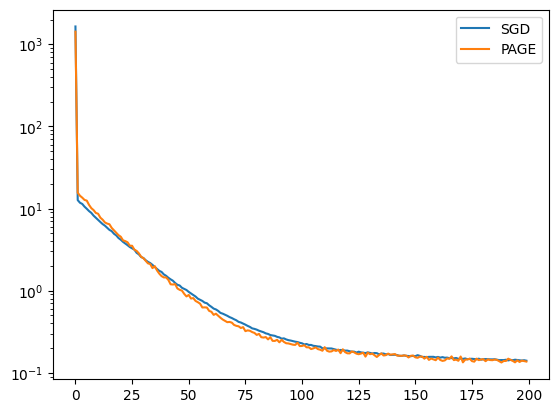

In [ ]:
plt.plot(losses_sgd, label='SGD')
plt.plot(losses_page, label='PAGE')
plt.yscale('log')
plt.legend()

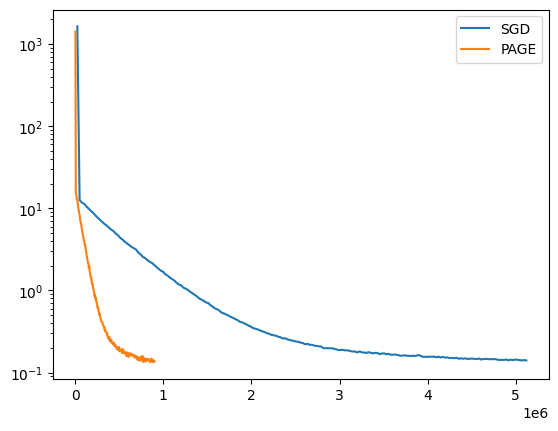

In [8]:
plt.plot(x_sgd, losses_sgd, label='SGD')
plt.plot(x_page, losses_page, label='PAGE')
plt.yscale('log')
plt.legend()